In [1]:
import datetime as dt
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
from arch.unitroot import VarianceRatio
from arch.univariate import ARX, GARCH
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.notebook import tqdm

In [2]:
data = yf.download("KCHOL.IS", period="max", start="2018-01-03")
data.drop(["Open", "High", "Low", "Close", "Volume"], axis=1, inplace=True)
data.rename(columns={"Adj Close": "Price"}, inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Price
Date,
2018-01-02,17.516148
2018-01-03,17.006323
2018-01-04,16.714993
2018-01-05,16.906178
2018-01-08,16.787825
...,...
2021-08-27,23.600000
2021-08-31,23.040001
2021-09-01,23.219999


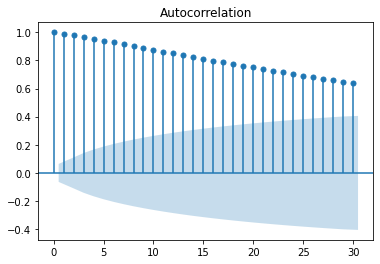

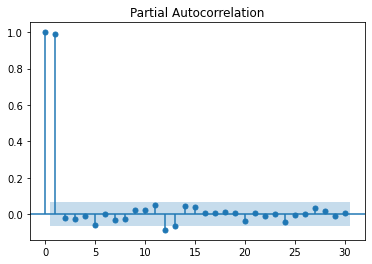

In [3]:
plot_acf(data)
plot_pacf(data)
plt.show()

In [4]:
VarianceRatio(data)  # Price is unpredictable!!!

Test Statistic,0.318
P-value,0.751
Lags,2


In [5]:
# Calculate returns and squared returns
data["ret"] = np.log(data.Price) - np.log(data.Price.shift(1))
data["ret_sq"] = data["ret"] ** 2
data.dropna(inplace=True)

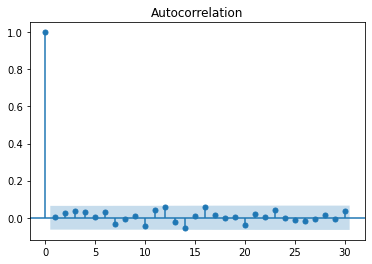

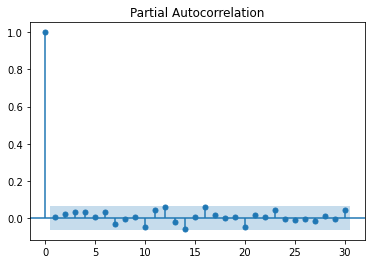

In [6]:
plot_acf(data["ret"])
plot_pacf(data["ret"])
plt.show()

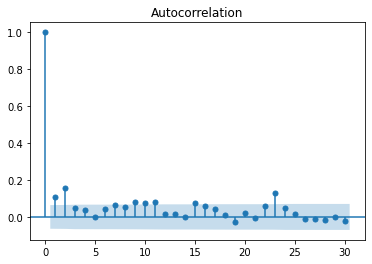

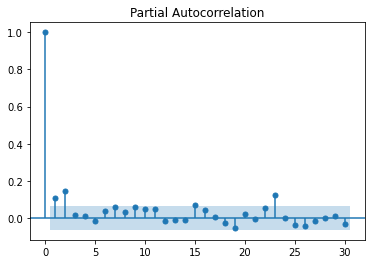

In [7]:
plot_acf(data["ret_sq"])
plot_pacf(data["ret_sq"])
plt.show()

In [8]:
# But, returns and squared returns are predictable!!
print(VarianceRatio(data["ret"]))
print(VarianceRatio(data["ret_sq"]))

     Variance-Ratio Test Results     
Test Statistic                 -8.492
P-value                         0.000
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
     Variance-Ratio Test Results     
Test Statistic                 -2.349
P-value                         0.019
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


In [9]:
returns_sq = 10000 * data["ret_sq"]

                           AR - GARCH Model Results                           
Dep. Variable:                 ret_sq   R-squared:                      -0.246
Mean Model:                        AR   Adj. R-squared:                 -0.250
Vol Model:                      GARCH   Log-Likelihood:               -3171.84
Distribution:                  Normal   AIC:                           6357.68
Method:            Maximum Likelihood   BIC:                           6391.40
                                        No. Observations:                  914
Date:                Sat, Sep 04 2021   Df Residuals:                      910
Time:                        09:33:50   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          1.3119      0.470      2.791  5.262e-03 

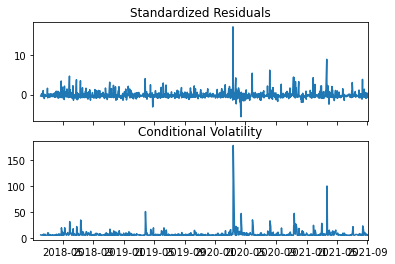

In [10]:
# AR - GARCH Model
ar_garch = ARX(returns_sq, lags=[1, 5, 22])
res_ar_garch = ar_garch.fit()
ar_garch.volatility = GARCH(p=1, q=1)
res_ar_garch = ar_garch.fit(update_freq=0, disp="off")

print(res_ar_garch.summary())
res_ar_garch.plot()
plt.show()

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       ret_sq   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2549.16
Distribution:      Standardized Student's t   AIC:                           5110.33
Method:                  Maximum Likelihood   BIC:                           5139.38
                                              No. Observations:                  936
Date:                      Sat, Sep 04 2021   Df Residuals:                      935
Time:                              09:33:50   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1

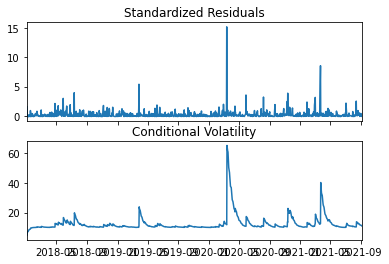

In [11]:
# GRJ-GARCH model
grja = arch_model(returns_sq, p=1, q=1, o=1, vol="GARCH", dist="t")
res_grja = grja.fit(disp="off")

print(res_grja.summary())
res_grja.plot()
plt.show()

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       ret_sq   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -2550.55
Distribution:      Standardized Student's t   AIC:                           5113.10
Method:                  Maximum Likelihood   BIC:                           5142.15
                                              No. Observations:                  936
Date:                      Sat, Sep 04 2021   Df Residuals:                      935
Time:                              09:33:51   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1

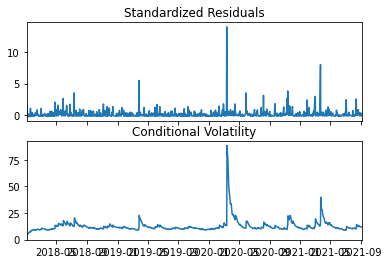

In [12]:
# E-GARCH model
egarch = arch_model(returns_sq, p=1, q=1, o=1, vol="EGARCH", dist="t")
res_egarch = egarch.fit(disp="off")

print(res_egarch.summary())
res_egarch.plot()
plt.show()

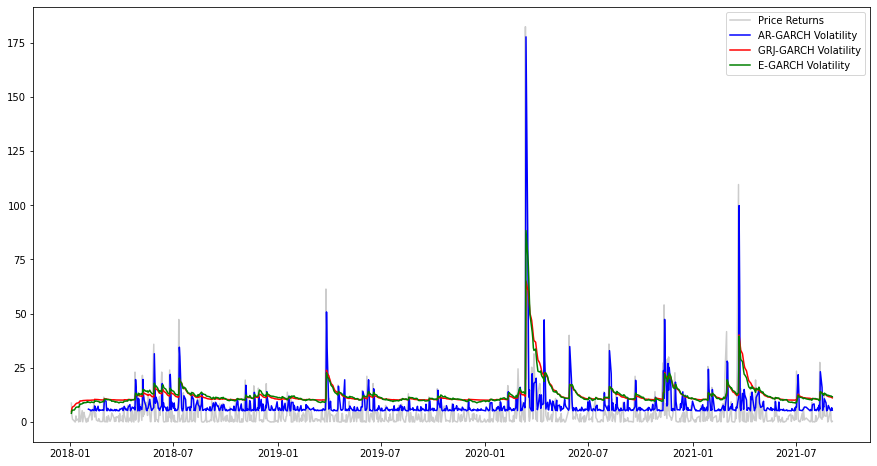

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(returns_sq, color="grey", alpha=0.4, label="Price Returns")
plt.plot(res_ar_garch.conditional_volatility, color="blue", label="AR-GARCH Volatility")
plt.plot(res_grja.conditional_volatility, color="red", label="GRJ-GARCH Volatility")
plt.plot(res_egarch.conditional_volatility, color="green", label="E-GARCH Volatility")
plt.legend(loc="upper right")
plt.show()

In [14]:
print(f"AR-GARCH BIC: {res_ar_garch.bic}")
print(f"GJR-GARCH BIC: {res_grja.bic}")
print(f"EGARCH BIC: {res_egarch.bic}")

AR-GARCH BIC: 6391.404788823991
GJR-GARCH BIC: 5139.376513570887
EGARCH BIC: 5142.149799027916


In [15]:
# Forecasting
# Rolling window
index = returns_sq.index
start_loc = 0
end_loc = np.where(index >= "2020-12-31")[0].min()
forecasts = {}
for i in tqdm(range(len(index) - end_loc + 1)):
    res = grja.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=5, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

res_rolling = pd.DataFrame(forecasts).T

# Recursive Rolling Window
forecasts = {}
for i in tqdm(range(len(index) - end_loc + 1)):
    res = grja.fit(last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=5, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

res_rec = pd.DataFrame(forecasts).T

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

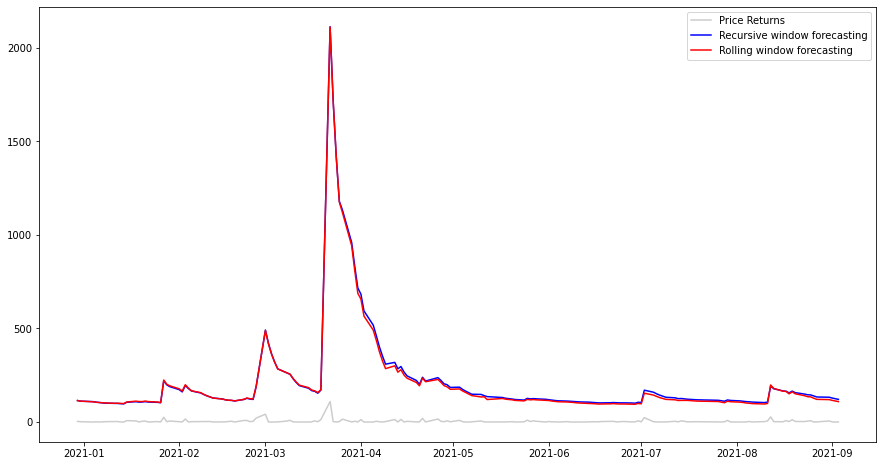

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(returns_sq.iloc[end_loc - 1 :], color="grey", alpha=0.4, label="Price Returns")
plt.plot(res_rec["h.1"], color="blue", label="Recursive window forecasting")
plt.plot(res_rolling["h.1"], color="red", label="Rolling window forecasting")
plt.legend(loc="upper right")
plt.show()